In [136]:
import matplotlib.pyplot as plt

In [137]:
def save_polygon_to_file(polygon, file_path):
    with open(file_path, 'w') as file:
        for item in polygon:
            file.write(f"{item[0]} {item[1]}\n")

def read_polygon_from_file(file_path):
    polygon = []
    with open(file_path, 'r') as file:
        for line in file:
            polygon.append(list(map(lambda x: float(x), line.split())))

    return polygon

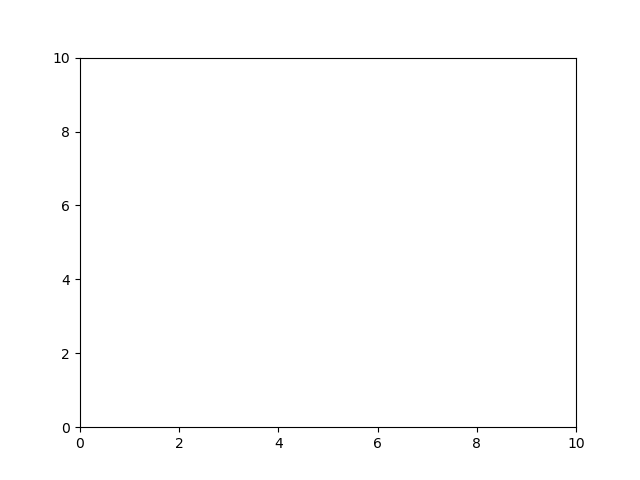

In [138]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])

given_polygon = []
points_x = []
points_y = []
eps = 0.1
finished = False

def onclick(event):
    global finished, given_polygon
    if len(points_x) > 0 and abs(points_x[0] - event.xdata) < eps and abs(points_y[0] - event.ydata) < eps: 
        given_polygon = list(zip(points_x, points_y))
        points_x.append(points_x[0])
        points_y.append(points_y[0])
        finished = True
    if not finished:
        points_x.append(event.xdata)
        points_y.append(event.ydata)
        col = 'blue'
    else:
        col = 'green'
    plt.plot(points_x, points_y, '.', c=col)
    plt.plot(points_x, points_y, c=col)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [139]:
%matplotlib inline
save_polygon_to_file(given_polygon, "polygon.txt")

In [140]:
given_polygon

[]

In [141]:
def is_y_monotonic(polygon):
    """
    Sprawdza, czy wielokąt jest y-monotoniczny.
    
    :param polygon: Lista wierzchołków wielokąta w formacie [(x1, y1), (x2, y2), ...]
                    Wierzchołki są podane przeciwnie do ruchu wskazówek zegara.
    :return: True, jeśli wielokąt jest y-monotoniczny, w przeciwnym razie False.
    """
    n = len(polygon)
    if n < 3:
        return False

    min_y_index = min(range(n), key=lambda i: polygon[i][1])
    max_y_index = max(range(n), key=lambda i: polygon[i][1])

    current_index = min_y_index
    while current_index != max_y_index:
        next_index = (current_index + 1) % n
        if polygon[next_index][1] < polygon[current_index][1]:
            return False
        current_index = next_index

    current_index = max_y_index
    while current_index != min_y_index:
        next_index = (current_index + 1) % n
        if polygon[next_index][1] > polygon[current_index][1]:
            return False
        current_index = next_index

    return True

In [142]:
polygon = [(0, 0), (2, 1), (1, 3), (0, 2)]  # Przeciwnie do ruchu wskazówek zegara
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]

print(is_y_monotonic(polygon))
print(is_y_monotonic(polygon_example_1))
print(is_y_monotonic(polygon_example_2))
print(is_y_monotonic(given_polygon))

True
True
False
False


In [143]:
def classify_vertices(polygon):
    def det(p, q, r):
        return (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])
    
    n = len(polygon)
    types = {
        "początkowe": [],
        "końcowe": [],
        "dzielące": [],
        "łączące": [],
        "prawidłowe": [],
    }
    
    for i in range(n):
        prev = polygon[(i - 1) % n]
        curr = polygon[i]
        next = polygon[(i + 1) % n]
        
        if curr[1] > prev[1] and curr[1] > next[1]:
            if det(prev, curr, next) < 0:
                types["dzielące"].append(curr)
            else:
                types["początkowe"].append(curr)
        elif curr[1] < prev[1] and curr[1] < next[1]:
            if det(prev, curr, next) < 0:
                types["łączące"].append(curr)
            else:
                types["końcowe"].append(curr)
        else:
            types["prawidłowe"].append(curr)
    
    return types

def plot_polygon_with_classification(polygon, vertex_types):
    plt.figure(figsize=(8, 6))
    
    xs, ys = zip(*polygon + [polygon[0]])
    plt.plot(xs, ys, color="black", linestyle="-", linewidth=1, label="Polygon")
    
    colors = {
        "początkowe": "green",
        "końcowe": "red",
        "łączące": "darkblue",
        "dzielące": "blue",
        "prawidłowe": "brown",
    }
    
    for vertex_type, vertices in vertex_types.items():
        x, y = zip(*vertices) if vertices else ([], [])
        plt.scatter(x, y, label=vertex_type.capitalize(), color=colors[vertex_type])
    
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Klasyfikacja wierzchołków wielokąta")
    plt.axis("equal")
    plt.show()

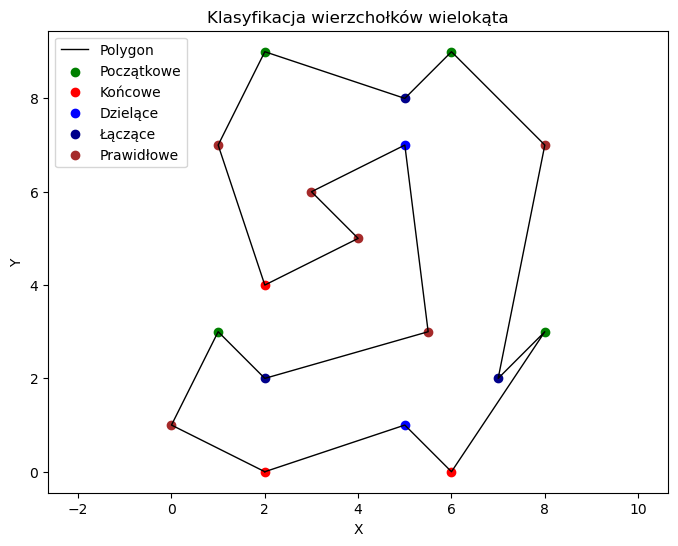

In [144]:
vertex_types = classify_vertices(polygon_example_2)
plot_polygon_with_classification(polygon_example_2, vertex_types)

In [245]:
def sort_points(points):
    y_min = min(points, key=lambda p: p[1])[1]
    y_max = max(points, key=lambda p: p[1])[1]

    precision = 1e-6
    bucket_count = int((y_max - y_min) / precision) + 1

    buckets = [[] for _ in range(bucket_count)]

    for point in points:
        bucket_index = int((point[1] - y_min) / precision)
        buckets[bucket_index].append(point)

    for bucket in buckets:
        bucket.sort(key=lambda p: -p[0])

    sorted_points = [point for bucket in buckets for point in bucket]
    
    return sorted_points[::-1]


def triangulate(polygon):
    def to_sides(polygon):
        n = len(polygon)
        top = polygon.index(max(polygon, key= lambda x: x[1]))
        bottom = polygon.index(min(polygon, key= lambda x: x[1]))
        left = set()
        right = set()
        i = top
        while i != bottom:
            left.add(i)
            i = (i+1)%n
        while i != top:
            right.add(i)
            i = (i+1)%n
        return left, right
    
    def neighbours(a, b):
        return abs(a - b) in [1, len(polygon)-1]
    
    def det(p, q, r):
        val = (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])
        return val
    
    if not is_y_monotonic:
        return None

    left_chain, right_chain = to_sides(polygon)
    
    polygon = [[x, y, i] for i, (x, y) in enumerate(polygon)]
    
    vertices = sort_points(polygon)
    
    stack = [vertices[0], vertices[1]]
    diagonals = []
    for i in range(2, len(vertices)):
        current = vertices[i]
        if (current[2] in left_chain) != (stack[-1][2] in left_chain):
            while len(stack) > 1:  
                diagonals.append([stack[-1][2], current[2]])
                stack.pop()
            stack = [vertices[i-1], current]
        else:
            while len(stack) > 1 and (
                (current[2] in left_chain and det(stack[-2], stack[-1], current) > 0)
                or (current[2] in right_chain and det(stack[-2], stack[-1], current) < 0)
            ):
                if not neighbours(stack[-2][2], current[2]):  
                    diagonals.append([stack[-2][2], current[2]])
                stack.pop()
            stack.append(current)

    while len(stack) > 2:
        if not neighbours(stack[-1][2], stack[-2][2]):  
            diagonals.append([stack[-1][2], stack[-2][2]])
        stack.pop()

    return diagonals

In [236]:
def plot_polygon_and_triangulation(polygon, diagonals):
    xs, ys = zip(*polygon + [polygon[0]])
    plt.plot(xs, ys, color="black", linestyle="-", linewidth=1, label="Polygon")
    
    for idx, idx2 in diagonals:
        tx = polygon[idx][0], polygon[idx2][0]
        ty = polygon[idx][1], polygon[idx2][1]
        
        plt.plot(tx, ty, linestyle="--", color="red", alpha=0.7)
    
    x, y = zip(*polygon)
    plt.scatter(x, y, color="green", zorder=5, label="Vertices")
    
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Triangulacja wielokąta y-monotonicznego")
    plt.axis("equal")
    plt.show()

[[5, 3], [3, 1], [1, 6], [3, 6]]


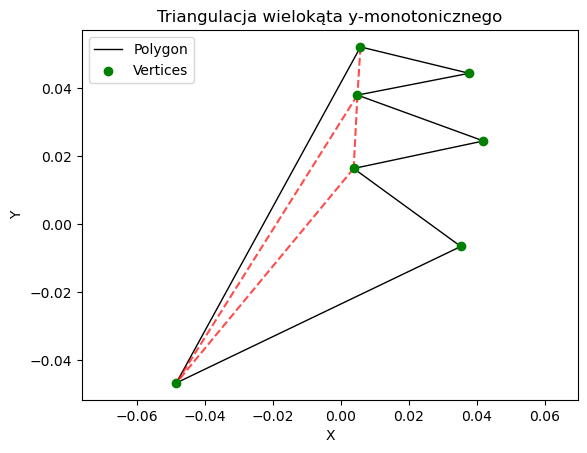

In [238]:
polygon_bit = [(0.03523160349938177, -0.0065379891676061175),
               (0.0037396680155108025, 0.01637867749906055),
               (0.041884829305833385, 0.02446691279317821),
               (0.004848538983252729, 0.03794730495004095),
(0.03767111962841403, 0.04435049122455076),
(0.005735635757446289, 0.05210171671474684),
(-0.04837726746836017, -0.0466421558342728)
]

triangles = triangulate(polygon_bit)
print(triangles)
plot_polygon_and_triangulation(polygon_bit, triangles)

In [239]:
import os

folder_path = 'testy'
def run_test(alg):
    test_files = sorted(os.listdir(folder_path)) 
    for i in range(1, len(test_files)//2 + 1):
        in_file = os.path.join(folder_path, f"test_3_3_{i}.in")
        out_file = os.path.join(folder_path, f"test_3_3_{i}.out")

        with open(in_file, 'r') as f:
            polygon = [
                (float(line.split()[0]), float(line.split()[1])) 
                for line in f.readlines()
            ]

        with open(out_file, 'r') as f:
            diagonals = [
                (float(line.split()[0]), float(line.split()[1])) 
                for line in f.readlines()
            ]

        ans = alg(polygon)
        
        print(f"Test {i}: OK")

In [240]:
run_test(triangulate)

Test 1: OK
Test 2: OK
Test 3: OK
Test 4: OK
Test 5: OK
Test 6: OK
Test 7: OK
Test 8: OK
Test 9: OK
Test 10: OK


In [270]:
import imageio.v2 as imageio


def triangulate_with_visualization(polygon, output_gif='triangulation.gif'):
    def to_sides(polygon):
        n = len(polygon)
        top = polygon.index(max(polygon, key=lambda x: x[1]))
        bottom = polygon.index(min(polygon, key=lambda x: x[1]))
        left = set()
        right = set()
        i = top
        while i != bottom:
            left.add(i)
            i = (i + 1) % n
        while i != top:
            right.add(i)
            i = (i + 1) % n
        return left, right
    
    def neighbours(a, b):
        return abs(a - b) in [1, len(polygon) - 1]
    
    def det(p, q, r):
        val = (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])
        return val

    left_chain, right_chain = to_sides(polygon)
    polygon = [[x, y, i] for i, (x, y) in enumerate(polygon)]
    vertices = sort_points(polygon)
    
    stack = [vertices[0], vertices[1]]
    diagonals = []

    if not os.path.exists("frames"):
        os.mkdir("frames")
    
    frame_files = []

    def plot_polygon_and_diagonals(diagonals, step):
        plt.figure(figsize=(8, 8))
        plt.plot(*zip(*(point[:2] for point in polygon + [polygon[0]])), 'k-', lw=1.5, label="Polygon")
        plt.scatter(*zip(*polygon), color='blue', label="Vertices")
        
        for diag in diagonals:
            p1 = polygon[diag[0]]
            p2 = polygon[diag[1]]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r--', lw=1.5)

        plt.title(f"Step {step}")
        plt.legend()
        plt.axis('equal')
        frame_path = f"frames/frame_{step:03d}.png"
        frame_files.append(frame_path)
        plt.savefig(frame_path)
        plt.close()

    plot_polygon_and_diagonals(diagonals, step=0)

    for i in range(2, len(vertices)):
        current = vertices[i]
        if (current[2] in left_chain) != (stack[-1][2] in left_chain):
            while len(stack) > 1:
                diagonals.append([stack[-1][2], current[2]])
                plot_polygon_and_diagonals(diagonals, step=len(diagonals))
                stack.pop()
            stack = [vertices[i - 1], current]
        else:
            while len(stack) > 1 and (
                (current[2] in left_chain and det(stack[-2], stack[-1], current) > 0)
                or (current[2] in right_chain and det(stack[-2], stack[-1], current) < 0)
            ):
                if not neighbours(stack[-2][2], current[2]):
                    diagonals.append([stack[-2][2], current[2]])
                    plot_polygon_and_diagonals(diagonals, step=len(diagonals))
                stack.pop()
            stack.append(current)

    while len(stack) > 2:
        if not neighbours(stack[-1][2], stack[-2][2]):
            diagonals.append([stack[-1][2], stack[-2][2]])
            plot_polygon_and_diagonals(diagonals, step=len(diagonals))
        stack.pop()
            
    with imageio.get_writer(output_gif, mode='I', fps=2, loop=0) as writer:
        for filename in frame_files:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in frame_files:
        os.remove(filename)
    os.rmdir("frames")

    return diagonals

In [271]:
triangulate_with_visualization(polygon_example_1)

[[1, 6], [6, 2], [3, 5], [2, 5]]